# C51 - Categorical DQN

This is the implementation of Categorical DQN for discrete action space using environment pixel inputs.

## Setup arguments

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Image

import time

import torch
import random

from torch_rl.jupyter_utils import (
    WidgetParser,
    plot_metrics_notebook
)

from torch_rl.utils import (
    seed_everything,
    handle_terminal_ob,
    mp4_to_gif,
    MetricStore,
    SPS
)


parser = WidgetParser()
parser.add_widget(widgets.IntText(
    description='seed',
    value=1,
    tooltip="seed of the experiment"
))

parser.add_widget(widgets.Checkbox(
    description="torch-deterministic",
    value=True,
    disabled=False,
    indent=False,
    tooltip="if toggled, `torch.backends.cudnn.deterministic=False`"
))

parser.add_widget(widgets.Checkbox(
    description="cuda",
    value=True,
    disabled=False,
    indent=False,
    tooltip="if toggled, cuda will be enabled by default"
))

parser.add_widget(widgets.Checkbox(
    description="capture-video",
    value=False,
    disabled=False,
    indent=False,
    tooltip="whether to capture videos of the agent performances (check out `videos` folder)"
))

parser.add_widget(widgets.Text(
    description="env-id",
    value="BreakoutNoFrameskip-v4",
    tooltip="the id of the environment"
))

parser.add_widget(widgets.IntText(
    description='total-timesteps',
    value=10000000,
    tooltip="total timesteps of the experiments"
))

parser.add_widget(widgets.FloatText(
    description='learning-rate',
    value=1e-4,
    tooltip="the learning rate of the optimizer"
))

parser.add_widget(widgets.IntText(
    description='buffer-size',
    value=1000000,
    tooltip="the replay memory buffer size"
))

parser.add_widget(widgets.FloatText(
    description='gamma',
    value=0.99,
    tooltip="the discount factor gamma"
))

parser.add_widget(widgets.IntText(
    description='target-network-frequency',
    value=1000,
    tooltip="the timesteps it takes to update the target network"
))

parser.add_widget(widgets.IntText(
    description='batch-size',
    value=32,
    tooltip="the batch size of sample from the reply memory"
))

parser.add_widget(widgets.FloatText(
    description='start-e',
    value=1.0,
    tooltip="the starting epsilon for exploration"
))

parser.add_widget(widgets.FloatText(
    description='end-e',
    value=0.01,
    tooltip="the ending epsilon for exploration"
))

parser.add_widget(widgets.FloatText(
    description='exploration-fraction',
    value=0.10,
    tooltip="the fraction of `total-timesteps` it takes from start-e to go end-e"
))

parser.add_widget(widgets.IntText(
    description='learning-starts',
    value=80000,
    tooltip="timestep to start learning"
))

parser.add_widget(widgets.IntText(
    description='train-frequency',
    value=4,
    tooltip="the frequency of training"
))


IntText(value=1, description='seed', tooltip='seed of the experiment')

Checkbox(value=True, description='torch-deterministic', indent=False, tooltip='if toggled, `torch.backends.cud…

Checkbox(value=True, description='cuda', indent=False, tooltip='if toggled, cuda will be enabled by default')

Checkbox(value=False, description='capture-video', indent=False, tooltip='whether to capture videos of the age…

Text(value='BreakoutNoFrameskip-v4', description='env-id', tooltip='the id of the environment')

IntText(value=10000000, description='total-timesteps', tooltip='total timesteps of the experiments')

FloatText(value=0.0001, description='learning-rate', tooltip='the learning rate of the optimizer')

IntText(value=1000000, description='buffer-size', tooltip='the replay memory buffer size')

FloatText(value=0.99, description='gamma', tooltip='the discount factor gamma')

IntText(value=1000, description='target-network-frequency', tooltip='the timesteps it takes to update the targ…

IntText(value=32, description='batch-size', tooltip='the batch size of sample from the reply memory')

FloatText(value=1.0, description='start-e', tooltip='the starting epsilon for exploration')

FloatText(value=0.01, description='end-e', tooltip='the ending epsilon for exploration')

FloatText(value=0.1, description='exploration-fraction', tooltip='the fraction of `total-timesteps` it takes f…

IntText(value=80000, description='learning-starts', tooltip='timestep to start learning')

IntText(value=4, description='train-frequency', tooltip='the frequency of training')

### Parse inputs

In [3]:
args = parser.parse()

run_name = f"{args.env_id}__dqn__{args.seed}__{int(time.time())}"
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
seed_everything(args.seed, args.torch_deterministic)
display(f"using device {device}")

'using device cuda'

## Setup environment

In [4]:
import gym

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_rl.atari import (
    NoopResetEnv,
    MaxAndSkipEnv,
    EpisodicLifeEnv,
    ClipRewardEnv,
    FireResetEnv
)


def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

### Ensure environment compatibility

In [5]:
envs = gym.vector.SyncVectorEnv([make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


### Environment examples

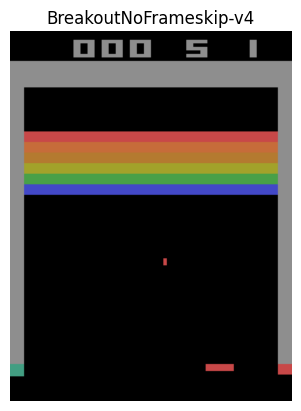

In [6]:
tmp_env = make_env(args.env_id, args.seed, 0, False, None)()
ob = tmp_env.reset()

plt.title(args.env_id)
plt.imshow(tmp_env.render("rgb_array"))
plt.axis('off')
plt.show()

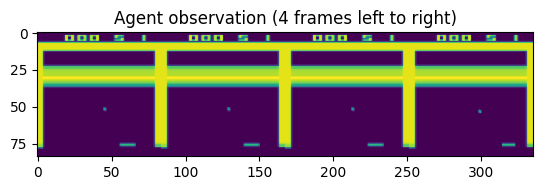

In [7]:
action = tmp_env.action_space.sample()
ob, reward, done, info = tmp_env.step(action)
plt.title("Agent observation (4 frames left to right)")
state_dim = tmp_env.observation_space.shape
plt.imshow(np.array(tmp_env.frames).transpose([0,2,1]).reshape([-1,state_dim[1]]).transpose([1,0]))
plt.show()

## Modeling

### Define Neural Network

In [8]:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x / 255.0)

### DQN training Wrapper

In [9]:
from torch_rl.dqn import (
    DQN,
    DQNTrainingWrapper
)


dqn = DQN(
    model_func=lambda: QNetwork(envs),
    device=device
).to(device)

wrapper = DQNTrainingWrapper(
    model = dqn,
    env=envs,
    device=device
)

optimizer = wrapper.get_optimizer(lr=args.learning_rate)

rb = wrapper.get_replay_buffer(
    buffer_size=args.buffer_size,
    optimize_memory_usage=True
)

/app/torch_rl/buffers.py:374: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 28.24GB > 3.95GB
  warnings.warn(


### Setup plots

In [10]:
from torch_rl.utils import SPS
def log_env_metrics(ms, step, infos):
    for info in infos:
        if "episode" in info.keys():
            ms.log_metric("episodic_return", info["episode"]["r"], step=step)
            ms.log_metric("episodic_length", info["episode"]["l"], step=step)


def plot_metric(global_step, ms, sps, show_model_metrics=True):
    env_metric_list = ["episodic_return", "episodic_length"]
    model_metric_list = ["q_values", "loss"]
    env_color_list = ["blue", "black"]
    model_color_list = ["green", "red"]
    if show_model_metrics:
        metric_list = env_metric_list + model_metric_list
        color_list = env_color_list + model_color_list
    else:
        metric_list = env_metric_list
        color_list = env_color_list

    sps.step(global_step)
    plot_metrics_notebook(ms, metric_list, color_list, sps=sps)

### DQN training loop

01% processed at 503 SPS. Remaining: 5 hour(s), 27 minute(s), 02 second(s) 



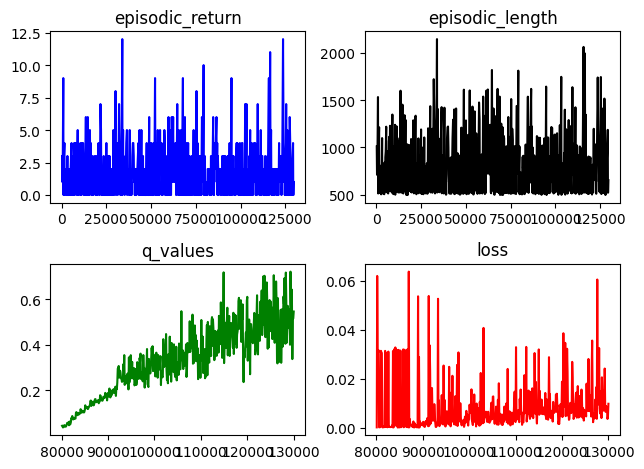

In [ ]:
ms = MetricStore()
sps = SPS(args.total_timesteps)
obs = envs.reset()
for global_step in range(args.total_timesteps):
    epsilon = wrapper.linear_schedule(
        args.start_e,
        args.end_e,
        args.exploration_fraction * args.total_timesteps,
        global_step
    )

    if random.random() < epsilon:
        actions = np.array([envs.single_action_space.sample()
                            for _ in range(envs.num_envs)])
    else:
        actions = dqn(torch.Tensor(obs).to(device)).cpu().numpy()

    next_obs, rewards, dones, infos = envs.step(actions)

    next_real_obs = handle_terminal_ob(next_obs, dones, infos)
    rb.add(obs, next_real_obs, actions, rewards, dones)
    obs = next_obs

    log_env_metrics(ms, global_step, infos)

    if global_step > args.learning_starts and global_step % args.train_frequency == 0:
        data = rb.sample(args.batch_size)
        q_values, loss = wrapper.train_step(data, gamma=args.gamma)

        if global_step % 100 == 0:
            ms.log_metric("q_values", q_values.mean().item(), step=global_step)
            ms.log_metric("loss", loss, step=global_step)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if global_step % args.target_network_frequency == 0:
            dqn.update_target_network()

    if global_step > 0 and global_step % 10000 == 0:
        plot_metric(global_step, ms, sps, global_step > args.learning_starts)

envs.close()

## Evaluation

In [ ]:
run_test_name = f"test-{run_name}"
test_env = make_env(args.env_id, args.seed, 0, True, run_test_name)()

ob = test_env.reset()
while True:
    action = dqn(torch.Tensor(np.array([ob])).to(device)).cpu().numpy()[0]
    ob, reward, done, info = test_env.step(action)
    if done:
        print(f'episodic_return={info["episode"]["r"]}, episodic_length={info["episode"]["l"]}')
        break


### Display full evaluation

In [ ]:
mp4_path = f"videos/{run_test_name}/rl-video-episode-0.mp4"
gif_path = f"images/dqn_atari_test.gif"

mp4_to_gif(mp4_path, gif_path)
Image(url=gif_path, width=500, height=500)